# Python ile uçtan uca makine öğrenmesi

Bu çalışmada Python kullanarak en otomatik fonksiyonlar ile uçtan uca bir makine öğrenmesi yapmaya çalışacağız. scikit-learn
kütphanesinin sağladığı bütün fonksiyonellikten yararlanıp en az müdahale ile ve en hızlı şekilde nasıl bir prototip model 
yaratabiliriz bunu görmeye çalışacağız.

Öncelikle kullanacağız kütüphaneleri çağıralım.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import loguniform
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xb

import warnings

pd.set_option ('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


model olarak  burada popüler olan olan xgboost ve GradientBoostingRegressor kullanmayı seçtim, regresyonda çok sık kullanılan bu modeller böyle bir çalışma için uygun olacaktır.

Veri setimiz github ta bulduğum 6k satırlı ve ikinci el araba fiyatlarını içeriyor. Burada amacımız
ikinci el araç fiyatını verilen girdiler ile tahminlemeye çalışmak olacak.

Burada en iyi skoru bulmak gibi bir amaca çok girmeyeceğiz çünkü göstermek istediğim hızlıca nasıl bir makine öğrenmesi pipeline ı kurabiliriz.

Veriyi github'ta herhangi bir çalışma arayarak hızlıca buldum, siz de farklı veriler üstünden kodlara fazla müdahale etmeden
çalışma yapabilirsiniz

In [2]:
data=pd.read_csv("https://raw.githubusercontent.com/sagnikghoshcr7/Car-Price-Prediction/master/data/dataset.csv")
data=data.drop(["Unnamed: 0", "New_Price"], axis=1)
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.000,1.750
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.000,12.500
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.000,4.500
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.000,6.000
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.000,17.740


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 564.4+ KB


Fonksiyonlarımıza bakmadan önce hızlıca bazı sayısal değerlerin dağılımına bakabiliriz. 

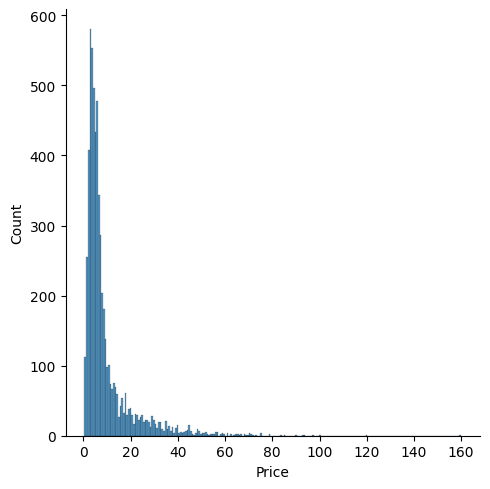

In [4]:
sns.displot(data, x="Price")
plt.show()

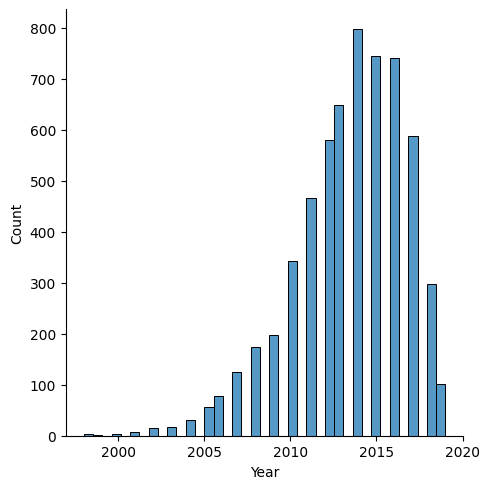

In [5]:
sns.displot(data, x="Year")
plt.show()

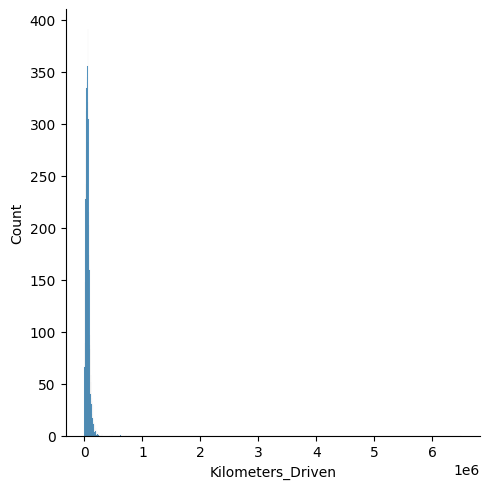

In [6]:
sns.displot(data, x="Kilometers_Driven")
plt.show()

Şimdi Makine öğrenmesi fonksiyonları oluşturmaya başlayabilirz.

- Modelimiz için doğru parametrelere seçmek iyi çalışan bir model için önemli bir adım.

- Manuel şekilde testler yapıp en iyisini bulmak büyük bir zaman kaybı olabilir bu yüzden bu işi
daha hızlı ve otomatik yapan algoritmalar ortaya çıktı.
Scikit-learn kütüphanesi bu konuda oldukça yardımcı ve çeşitli fonksiyonlar barındırıyor.
Ben bu çalışmada hızlı olduğu için HalvingRandomSearchCV 'yi tercih ettim ancak bu deneysel aşamada olduğu
için sklearn dökümantasyonları bu riski alarak kullanmamızı öneriyor.

- HalvingRandomSearchCV succesive halving metoduyla çalışır, bu metod bir multi-armed bandit metodur aslında 
çalışma prensibi verideki bir kısım kaynağı kullanarak kötü performans gösteren parametre değerlerini
hızlıca eliyor böylece parametrelerin optimal değerine diğer gridsearch algoritmalara göre daha hızlı
varmış oluyor.

- Gireceğimiz veride bazı kategorik veriler de mevcut olabilir, bu yüzden feature_engineering isimli bir fonksiyon yaratıp,
burada girdi verisetindeki sütunları tiplerine göre ayırıp StandardScaler ve OneHotEncoder ile tranform ettim.


In [7]:
def grid_seach_algo (data, model, params):
    model = model
    params = params
    preprocessor = feature_engineering(data)
    X = data.drop ('Price', axis=1)
    y = data[['Price']]
    data_prepared = preprocessor.fit_transform (X)

    clf = HalvingRandomSearchCV (model, 
                                 params,
                                 scoring='neg_mean_absolute_percentage_error',
                                 verbose=-1,
                                 n_candidates="exhaust",
                                 n_jobs=-1)
    clf.fit (data_prepared, y.values.ravel ())
    
    return clf 

In [8]:
def feature_engineering (data):
    
    #sayısal değerler içeren sütunları bulma ve pipeline oluşturma
    numeric_features = [col for col in data.columns if data[col].dtype != "O"]
    numeric_features.remove ('Price')#target değerimiz burada olmamalı
    numeric_transformer = Pipeline (
              steps=[("imputer", SimpleImputer (strategy="mean")), ("scaler", StandardScaler ())])
    
    #kategorik değerler içeren sütunları bulma ve pipeline oluşturma
    categorical_features = [col for col in data.columns if data[col].dtype == "O"]
    categorical_transformer = OneHotEncoder (handle_unknown="ignore")

    preprocessor = ColumnTransformer ( transformers=[
                                                     ("num", numeric_transformer, numeric_features),
                                                     ("cat", categorical_transformer, categorical_features),
                                                     ]
                                     )
    return preprocessor

In [9]:
def model_scores (data):
    preprocessor = feature_engineering (data)
    
    #kullanacağımız modeller için parametre havuzu oluşturma
    param_grid_xgboost = {'max_depth': [3, 6, 10],
                          'learning_rate': [0.01, 0.05, 0.1],
                          'n_estimators': [100, 500, 1000],
                          'colsample_bytree': [0.3, 0.7]}
    
    param_grid_gbr = {"n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
                      "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
                      "learning_rate": loguniform (0.01, 1)}

            

    X = data.drop ('Price', axis=1)
    y = data[['Price']]

    X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state=42)

    #en iyi modelin parametrelerini bulma ve bunu pipeline a ekleme
    grid_result_xgboost = grid_seach_algo (data, xb.XGBRegressor (), param_grid_xgboost)
    besties_xgboost = grid_result_xgboost.best_params_
    clf_xgboost = Pipeline (
                    steps=[("preprocessor", preprocessor), ("regressor", xb.XGBRegressor (**besties_xgboost))])

               

    grid_result_gbr = grid_seach_algo (data, GradientBoostingRegressor (), param_grid_gbr)
    besties_gbr = grid_result_gbr.best_params_
    clf_gbr = Pipeline (steps=[("preprocessor", preprocessor), ("regressor", GradientBoostingRegressor (**besties_gbr))])
            

    clf_xgboost.fit (X_train, y_train)
    clf_gbr.fit (X_train, y_train)

    predictions_xgboost = clf_xgboost.predict (X_test)
    predictions_gbr = clf_gbr.predict (X_test)
         

    results = {'xgboost_accuracy_score': clf_xgboost.score (X_test, y_test),
                'gbr_accuracy_score': clf_gbr.score (X_test, y_test),

                'xgboost_mea_score': str (mean_absolute_error (predictions_xgboost, y_test)),
                'gbr_mea_score': str (mean_absolute_error (predictions_gbr, y_test)),

                'xgboost_mape_score': str (mean_absolute_percentage_error (predictions_xgboost, y_test)),
                'gbr_mape_score': str (mean_absolute_percentage_error (predictions_gbr, y_test)),

                'xgboost_best_params': besties_xgboost,
                'gbr_best_params': besties_gbr
              }

    return results

İlk çalıştırmamızda veriye hiç müdehale etmeden nasıl skorlar alacağımıza bakalım. 

In [10]:
besties = model_scores(data)
besties

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 6
min_resources_: 10
max_resources_: 6019
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 10
----------
iter: 1
n_candidates: 18
n_resources: 30
----------
iter: 2
n_candidates: 6
n_resources: 90
----------
iter: 3
n_candidates: 2
n_resources: 270
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 10
max_resources_: 6019
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 601
n_resources: 10
----------
iter: 1
n_candidates: 201
n_resources: 30
----------
iter: 2
n_candidates: 67
n_resources: 90
----------
iter: 3
n_candidates: 23
n_resources: 270
----------
iter: 4
n_candidates: 8
n_resources: 810
----------
iter: 5
n_candidates: 3
n_resources: 2430


{'xgboost_accuracy_score': 0.4105195535658379,
 'gbr_accuracy_score': 0.8413734976004645,
 'xgboost_mea_score': '4.370583965205406',
 'gbr_mea_score': '1.7311315139641363',
 'xgboost_mape_score': '0.6042636708505607',
 'gbr_mape_score': '0.317835659818613',
 'xgboost_best_params': {'n_estimators': 100,
  'max_depth': 3,
  'learning_rate': 0.01,
  'colsample_bytree': 0.7},
 'gbr_best_params': {'learning_rate': 0.5447993210956236,
  'max_leaf_nodes': 10,
  'n_estimators': 500}}

Skorlara baktığımızda müdahale olmadan en iyi modelimiz GrdaientBoostingRegressor olmuş gibi, tabi skorlama yöntemi de önemli olduğu
için kendi probleminize en uygun skoru siz de seçebilirsiniz. 
Ben burada **mean square error**, **negative mean absolute percentage error** ve  **mean absolute percentage** error kullandım.  
Ayrıca size bnu skorları sağlayacak parametreleri de görebiliyorsunuz.

şimdi km ve fiyat değerlerinde anomalik değerleri yakınlaştırma metodu ile %5 ve %95 değerlerine yakınlaştırıp tekrar
deneyip skora bakabiliriz.

Bunu yaparken stackoverflow dan bulduğum bir çözüm ile yaptım, linkini de bırakıyorum. 

In [12]:
#https://stackoverflow.com/a/55471980
def cap_data(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.05,0.95]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

data=cap_data(data)
data

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000.000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.000,1.750
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000.000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.000,12.500
2,Honda Jazz V,Chennai,2011,46000.000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.000,4.500
3,Maruti Ertiga VDI,Chennai,2012,87000.000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.000,6.000
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670.000,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.000,17.740
...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365.000,Diesel,Manual,First,28.4 kmpl,1248 CC,74 bhp,5.000,4.750
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000.000,Diesel,Manual,First,24.4 kmpl,1120 CC,71 bhp,5.000,4.000
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000.000,Diesel,Manual,Second,14.0 kmpl,2498 CC,112 bhp,7.000,2.900
6017,Maruti Wagon R VXI,Kolkata,2013,46000.000,Petrol,Manual,First,18.9 kmpl,998 CC,67.1 bhp,5.000,2.650


normalizasyon sonucu km ve price değerlerimize tekrar bakabiliriz.

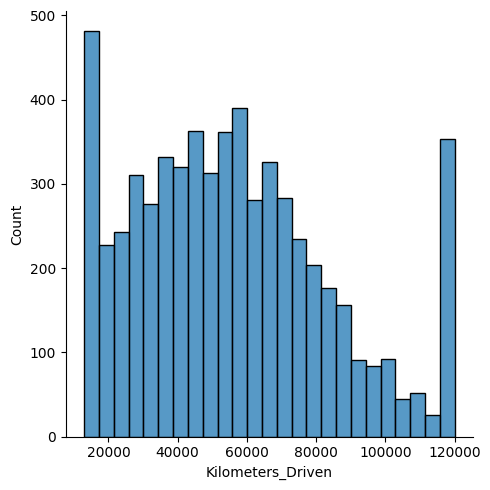

In [13]:
sns.displot(data, x="Kilometers_Driven")
plt.show()

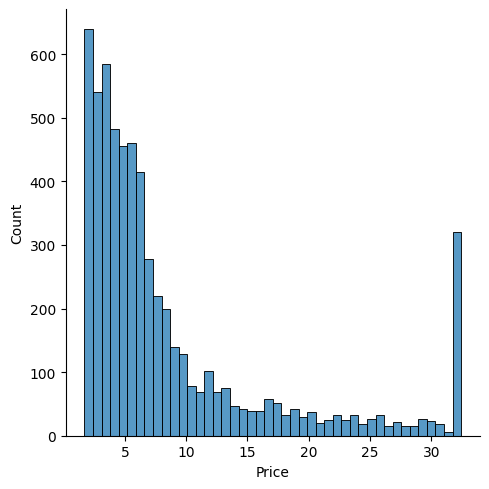

In [14]:
sns.displot(data, x="Price")
plt.show()

In [15]:
besties = model_scores(data)
besties

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 6
min_resources_: 10
max_resources_: 6019
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 10
----------
iter: 1
n_candidates: 18
n_resources: 30
----------
iter: 2
n_candidates: 6
n_resources: 90
----------
iter: 3
n_candidates: 2
n_resources: 270
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 10
max_resources_: 6019
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 601
n_resources: 10
----------
iter: 1
n_candidates: 201
n_resources: 30
----------
iter: 2
n_candidates: 67
n_resources: 90
----------
iter: 3
n_candidates: 23
n_resources: 270
----------
iter: 4
n_candidates: 8
n_resources: 810
----------
iter: 5
n_candidates: 3
n_resources: 2430


{'xgboost_accuracy_score': 0.8345172866572028,
 'gbr_accuracy_score': 0.9063989465122364,
 'xgboost_mea_score': '2.1188986550222317',
 'gbr_mea_score': '1.4640366399311902',
 'xgboost_mape_score': '0.2528434334726373',
 'gbr_mape_score': '0.19198461532532085',
 'xgboost_best_params': {'n_estimators': 500,
  'max_depth': 3,
  'learning_rate': 0.05,
  'colsample_bytree': 0.7},
 'gbr_best_params': {'learning_rate': 0.2068843637202841,
  'max_leaf_nodes': 100,
  'n_estimators': 500}}

Normalizasyon sonrası sonuçlara baktığımızda bazı skorlarımızın iyileştiğini ve parametrelerin de değiştiğini görebiliyoruz, 
doğal olarak beklenen bir şeydi çünkü bir makine öğrenmesi algoritması anomalik değerlere karşı hassas olabiliyor. 

Bu çalışmada umarım basitçe nasıl bir fonksiyonel makine öğrenmesi mimarisi yaratbileceğinize dair güzel bir örnek olmuştur.
Siz de kendi verileriniz ve farklı yaklaşımlarınız da yeni testler denemeyi ihmal etmeyin.

Okuduğunuz için teşekkürler.